# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [1]:
# Import necessary libraries
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import classification_report, accuracy_score

# from sklearn.metrics import accuracy_score, mean_squared_error

# Import chosen baseline model
from sklearn.linear_model import LogisticRegression

# configuration
input_folder = "../3_Model/temp_processed_data_241208"                  # folder with preprocessed imagefiles
categories = ["with_seamount_manual1", "without_seamounts_manual1"]      # Subfolders in `image_folder` with catgeories

## Model Choice

In order to reduce complexity as much as possible, we have opted for your LogisticRegression model. The model is provided by the sklearn framework as an implementation and can process image data. 

The image data must first be converted to vector format and the image colour values must be normalized to values between 0..1.


## Feature Selection

Since the goal of the project is binary classification and we are working with image data as input, we worked with all features as input, but reduced the image data to a size of 128x128 pixels and did not apply any special convolution or pooling.

In this step we 
- Read-in the files
- split in test, validation and trainingsdata sets
- undersample traingsdata
- normalize data in all sets


In [2]:
# Determine the sample image size by picking one sample image out of folders
def get_first_image_size(input_folder, categories):
    for category in categories:
        category_folder = os.path.join(input_folder, category)
        if os.path.exists(category_folder) and os.path.isdir(category_folder):
            # List of files in the folder
            for file_name in os.listdir(category_folder):
                file_path = os.path.join(category_folder, file_name)
                if os.path.isfile(file_path):  # Make sure it's a file
                    image = cv2.imread(file_path)
                    if image is not None:
                        # Return image size (height, width)
                        return image.shape[0], image.shape[1]  # Height and width
    return None, None  # If no image is found

image_size = [0, 0]
image_size[0], image_size[1] = get_first_image_size(input_folder, categories)

print(f"Image sample size of {image_size[0]}x{image_size[1]} Pixel size!\n")

# Load processed dataset
def load_data(directory, categories):
    data, labels = [], []
    category_counts = {} 
    for label, category in enumerate(categories):
        category_folder = os.path.join(directory, category)
        file_count = 0
        for file_name in os.listdir(category_folder):
            file_path = os.path.join(category_folder, file_name)
            image = cv2.imread(file_path)
            if image is not None:
                data.append(image.flatten())  # Flatten to vector for regression
                labels.append(label)
                file_count += 1
        category_counts[category] = file_count
    return np.array(data), np.array(labels), category_counts

data, labels, category_counts = load_data(input_folder, categories)

print("Number of samples per category:")
for category, count in category_counts.items():
    print(f"Category '{category}': {count} images")

# Function for balancing by undersampling
def balance_classes_undersample(X, y):
    unique_classes = np.unique(y)
    min_count = min([np.sum(y == cls) for cls in unique_classes])  # Minimum count per class
    X_balanced, y_balanced = [], []
    
    for cls in unique_classes:
        X_cls = X[y == cls]
        y_cls = y[y == cls]
        
        # Undersample the class to the minimum count
        X_undersampled, y_undersampled = resample(
            X_cls, y_cls, 
            replace=False,  # No replacement
            n_samples=min_count, 
            random_state=42
        )
        X_balanced.append(X_undersampled)
        y_balanced.append(y_undersampled)
    
    # Combine the classes back into one array
    return np.vstack(X_balanced), np.hstack(y_balanced)


# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print count of samples per class in training data
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print("\nCount of samples per class in training data before undersampling:")
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} sample count")

# Undersampling only needed on training data
X_train, y_train = balance_classes_undersample(X_train, y_train)

unique_classes, class_counts = np.unique(y_train, return_counts=True)
print("Count of samples per class in training data after undersampling:")
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} sample count")

# Normalize pixel values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Image sample size of 128x128 Pixel size!

Number of samples per category:
Category 'with_seamount_manual1': 500 images
Category 'without_seamounts_manual1': 500 images

Count of samples per class in training data before undersampling:
Class 0: 350 sample count
Class 1: 350 sample count
Count of samples per class in training data after undersampling:
Class 0: 350 sample count
Class 1: 350 sample count


## Implementation

[Implement your baseline model here.]



In [3]:
# Train logistic regression model
print("Training Logistic Regression Model...")
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train, y_train)

Training Logistic Regression Model...


LogisticRegression(max_iter=1000, random_state=42)

## Evaluation

The code evaluates the model's performance using the following metrics:

**Classification Report**: Includes precision, recall, F1-score, and support for each class, providing a comprehensive view of the model's performance across the validation and test datasets.

**Accuracy Score**: Calculates the overall percentage of correctly classified samples for both validation and test sets.

**Visualization of Predictions**: Randomly selects and displays test images with their true and predicted labels, offering qualitative insights into the model's classification behavior.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label Mapping in Training Data:
Label 0: with_seamount_manual1
Label 1: without_seamounts_manual1

Validation Results:
                           precision    recall  f1-score   support

    with_seamount_manual1       0.86      0.83      0.85        72
without_seamounts_manual1       0.85      0.87      0.86        78

                 accuracy                           0.85       150
                macro avg       0.85      0.85      0.85       150
             weighted avg       0.85      0.85      0.85       150

Validation Accuracy: 0.8533333333333334

Test Results:
                           precision    recall  f1-score   support

    with_seamount_manual1       0.90      0.78      0.84        78
without_seamounts_manual1       0.79      0.90      0.84        72

                 accuracy                           0.84       150
                macro avg       0.84      0.84      0.84       150
             weighted avg       0.85      0.84      0.84       150

Test Accuracy: 0

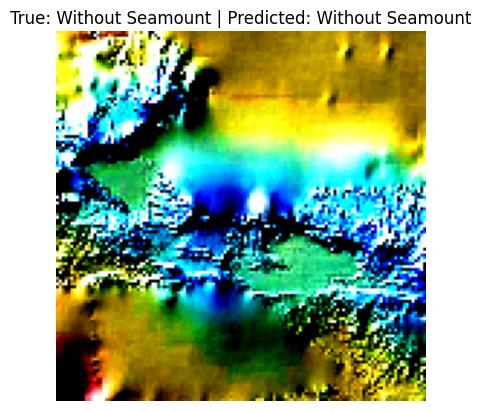

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


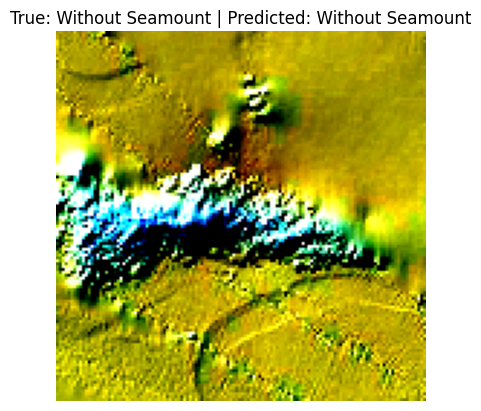

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


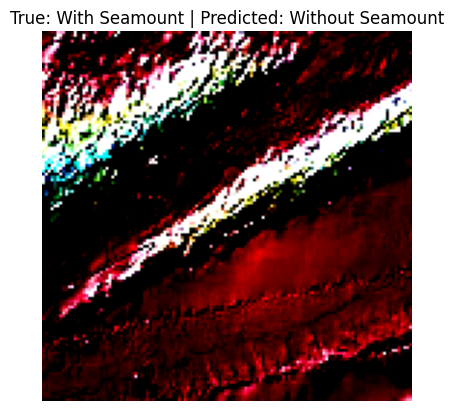

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


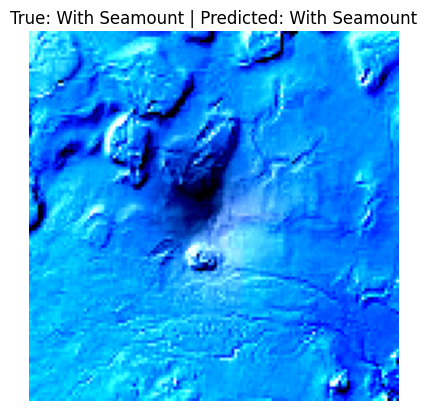

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


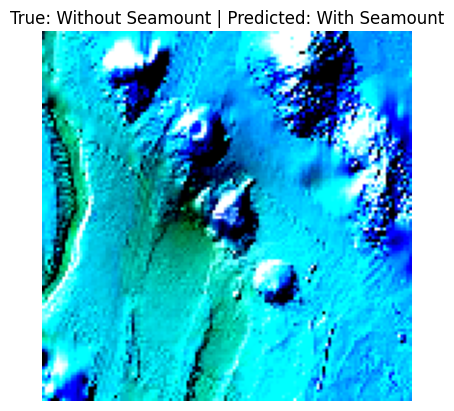

In [4]:
# show class mapping number to lable
unique_labels = np.unique(y_train)

print("Label Mapping in Training Data:")
for label in unique_labels:
    print(f"Label {label}: {categories[label]}")

# Evaluate model
y_val_pred = logistic_model.predict(X_val)
y_test_pred = logistic_model.predict(X_test)

print("\nValidation Results:")
print(classification_report(y_val, y_val_pred, target_names=categories))
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))

print("\nTest Results:")
print(classification_report(y_test, y_test_pred, target_names=categories))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

# Visualize a few test images with predictions
def visualize_predictions(X, y_true, y_pred, num_images=5):
    indices = np.random.choice(len(X), num_images, replace=False)
    for i in indices:
        img = X[i].reshape(image_size[0], image_size[1], 3)  # Reshape to original image dimensions
        true_label = "With Seamount" if y_true[i] == 1 else "Without Seamount"
        predicted_label = "With Seamount" if y_pred[i] == 1 else "Without Seamount"
        
        plt.figure()
        plt.imshow(img)
        plt.title(f"True: {true_label} | Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

print("\nVisualizing Predictions on Test Set:")
visualize_predictions(X_test, y_test, y_test_pred, num_images=5)
